## Config

In [1]:
import sys
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../../settings.ini'))

sys.path.insert(0, config.get('PATHS','libs_path'))
engine_path = config.get('DATABASE','engine_path')
local_path = '../data/'


## Imports

In [37]:
import postgres #from local file postgres.py
import commons
from commons import inline_table_xml, download_file, download_zip_file, extract_zip_file #from local file commons.py
from importlib import reload

import json
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine(engine_path)
db = postgres.PostgresDriver(engine)

# Institution Directory

## Load file

In [24]:
reload(commons)
from commons import download_file
dim_institutions = download_file("http://pacha.datawheel.us/datachile/education/establishments/analysis/2_performance/",
                                 local_path,
                                 "directorio_oficial_2016.csv",
                                 delimiter=';')

Already downloaded. Using: ../data/directorio_oficial_2016.csv


In [38]:
dim_institutions = dim_institutions.rename(lambda c: c.lower(), axis=1)
db.to_sql(dim_institutions, 'education', 'dim_educational_institutions_new')

DROP TABLE IF EXISTS education.dim_educational_institutions_new;
CREATE TABLE "education"."dim_educational_institutions_new" (
"agno" INTEGER,
  "rbd" INTEGER,
  "dgv_rbd" INTEGER,
  "nom_rbd" TEXT,
  "mrun" TEXT,
  "rut_sostenedor" TEXT,
  "p_juridica" INTEGER,
  "cod_reg_rbd" INTEGER,
  "cod_pro_rbd" INTEGER,
  "cod_com_rbd" INTEGER,
  "nom_com_rbd" TEXT,
  "cod_deprov_rbd" INTEGER,
  "nom_deprov_rbd" TEXT,
  "cod_depe" INTEGER,
  "cod_depe2" INTEGER,
  "rural_rbd" INTEGER,
  "fono_rbd" TEXT,
  "celular_rbd" TEXT,
  "dir_rbd" TEXT,
  "latitud" TEXT,
  "longitud" TEXT,
  "convenio_pie" INTEGER,
  "ens_01" INTEGER,
  "ens_02" INTEGER,
  "ens_03" INTEGER,
  "ens_04" INTEGER,
  "ens_05" INTEGER,
  "ens_06" INTEGER,
  "ens_07" INTEGER,
  "ens_08" INTEGER,
  "ens_09" INTEGER,
  "matricula" INTEGER,
  "estado_estab" INTEGER,
  "ori_religiosa" INTEGER,
  "ori_otro_glosa" TEXT,
  "pago_matricula" TEXT,
  "pago_mensual" TEXT
)
COPY "education"."dim_educational_institutions_new" ("agno","rbd","

# Registered Students

## Load file

In [4]:

facts_registered = download_file("http://pacha.datawheel.us/datachile/education/mineduc/3_tidy_data/3_registered/",
                                 local_path,
                                 "registered.csv")

Downloading... http://pacha.datawheel.us/datachile/education/mineduc/3_tidy_data/3_registered/registered.csv


## Ingest 

In [6]:
db.to_sql(facts_registered, 'education', 'fact_registered')

DROP TABLE IF EXISTS education.fact_registered;
CREATE TABLE "education"."fact_registered" (
"mrun" INTEGER,
  "anio_proceso" INTEGER,
  "sexo_id" INTEGER,
  "rbd" INTEGER,
  "codigo_ensenianza_id" INTEGER,
  "rama_educacional_id" TEXT,
  "grupo_dependencia_id" INTEGER,
  "anio_egreso" INTEGER,
  "promedio_notas" INTEGER,
  "puntajes_proceso_id" INTEGER,
  "puntaje_nem" REAL,
  "puntaje_ranking" REAL,
  "lyc_actual" REAL,
  "mate_actual" REAL,
  "hycs_actual" REAL,
  "ciencias_actual" REAL,
  "promlm_actual" REAL,
  "bea_id" REAL,
  "lyc_anterior" REAL,
  "mate_anterior" REAL,
  "hycs_anterior" REAL,
  "ciencias_anterior" REAL,
  "promlm_anterior" REAL,
  "tipo_identificacion_id" INTEGER,
  "comuna_datachile_id" INTEGER,
  "dia_nacimiento" INTEGER,
  "mes_nacimiento" INTEGER,
  "anio_nacimiento" INTEGER
)
COPY "education"."fact_registered" ("mrun","anio_proceso","sexo_id","rbd","codigo_ensenianza_id","rama_educacional_id","grupo_dependencia_id","anio_egreso","promedio_notas","puntajes_

## Check

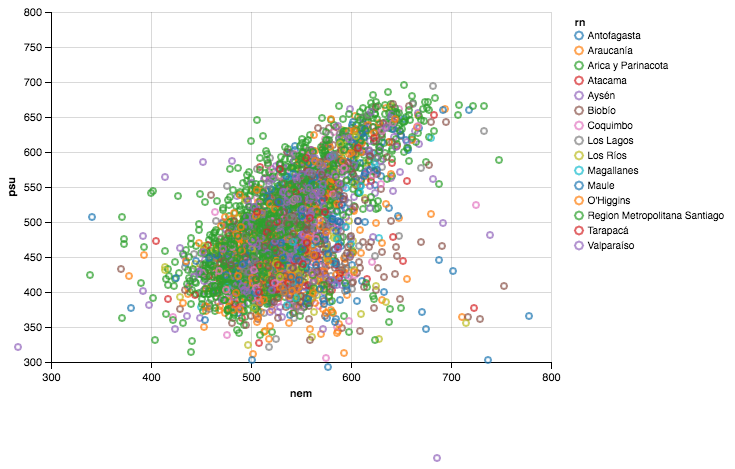

In [11]:
import altair as alt

df = pd.read_sql("""SELECT c.region_name as rn, rbd, AVG(promlm_actual) AS psu, AVG(puntaje_nem) AS nem 
               FROM education.fact_registered r
               INNER JOIN public.dim_comunas c ON c.id = r.comuna_datachile_id
               WHERE anio_proceso = 2015 AND promlm_actual IS NOT NULL AND puntaje_nem IS NOT NULL 
               GROUP BY c.region_name, rbd""", 
            engine)

chart = alt.Chart(df).mark_point().encode(
    x=alt.X('nem', scale=alt.Scale(domain=[300,800])),
    y=alt.Y('psu', scale=alt.Scale(domain=[300,800])),
    color=alt.Color('rn', type='nominal')
)
chart